In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import requests
import torch
from PIL import Image
from transformers import AutoImageProcessor, AutoModelForDepthEstimation

image_processor = AutoImageProcessor.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")
model = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf")

preprocessor_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

c:\Users\Gunte\Workspace\Workspace\projects\BKS\plant-identify\.venv\Lib\site-packages\huggingface_hub\file_download.py:130: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Gunte\.cache\huggingface\hub\models--depth-anything--Depth-Anything-V2-Small-hf. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
The image processor of type `DPTImageProcessor` is now loa

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/99.2M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/287 [00:00<?, ?it/s]

In [8]:
def predict_depth(
    image_source,
    model,
    image_processor,
):
    """
    Runs depth estimation on an image and returns a normalized depth map as a PIL Image.

    Args:
        image_source (str): Local image path or URL.
        model: Depth estimation model (e.g. HuggingFace model).
        image_processor: Corresponding image processor.

    Returns:
        PIL.Image.Image: Depth map (uint8, 0–255).
    """

    # Load image (URL or local file)
    if image_source.startswith("http"):
        image = Image.open(requests.get(image_source, stream=True).raw)
    else:
        image = Image.open(image_source)

    # Prepare image for the model
    inputs = image_processor(images=image, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)

    # Resize prediction back to original image size
    post_processed_output = image_processor.post_process_depth_estimation(
        outputs,
        target_sizes=[(image.height, image.width)],
    )

    predicted_depth = post_processed_output[0]["predicted_depth"]

    # Normalize to 0–255
    depth = (predicted_depth - predicted_depth.min()) / (
        predicted_depth.max() - predicted_depth.min()
    )
    depth = depth.detach().cpu().numpy()
    depth = (depth * 255).astype(np.uint8)

    return Image.fromarray(depth)

In [9]:
depth = predict_depth(
    image_source="../samples/tree1.png",
    model=model,
    image_processor=image_processor,
)

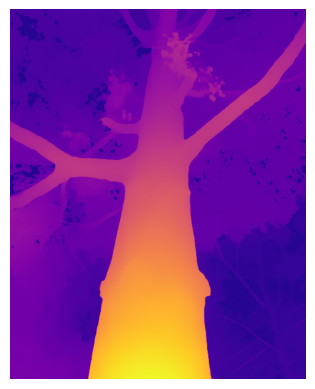

In [ ]:
plt.imshow(np.array(depth), cmap="plasma")
plt.axis("off")
plt.show()